# NVIDIA 주가예측 시계열 분석
# 1. 데이터 확인하기
## 데이터를 이해함으로써 특정한 주기의 계절성이나 특별한 현상을 가지는지에 대한 분석하자.

In [ ]:
# 패키지 설치하기
from datakit import utils
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

import itertools
import seaborn as sns
import polars as pl
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
def get_score(y_true, y_pred) :
    # MSE
    mse = mean_squared_error(y_true, y_pred)

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE
    rmse = np.sqrt(mse)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # MSPE (Mean Squared Percentage Error)
    mspe = np.mean(np.square((y_true - y_pred))/y_true)*100


    return mse, mae, rmse, mape, mspe

In [6]:
df = pd.read_csv("nvidia_stock_prices.csv")
df

,Date,Open,High,Low,Close,Volume
0,2004-01-02,0.196417,0.199083,0.192333,0.192333,436416000
1,2004-01-05,0.195250,0.199917,0.193500,0.198583,575292000
2,2004-01-06,0.198000,0.209417,0.197083,0.206667,1093344000
3,2004-01-07,0.204333,0.209500,0.202917,0.208500,673032000
4,2004-01-08,0.211083,0.212083,0.207250,0.209250,433752000
...,...,...,...,...,...,...
5028,2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000
5029,2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000
5030,2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000
5031,2023-12-28,49.643002,49.883999,49.411999,49.521999,246587000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5033 non-null   object 
 1   Open    5033 non-null   float64
 2   High    5033 non-null   float64
 3   Low     5033 non-null   float64
 4   Close   5033 non-null   float64
 5   Volume  5033 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.1+ KB


In [ ]:
# column을 시간으로 변경하기기
df.Date = pd.to_datetime(df.Date)
df


,Date,Open,High,Low,Close,Volume
0,2004-01-02,0.196417,0.199083,0.192333,0.192333,436416000
1,2004-01-05,0.195250,0.199917,0.193500,0.198583,575292000
2,2004-01-06,0.198000,0.209417,0.197083,0.206667,1093344000
3,2004-01-07,0.204333,0.209500,0.202917,0.208500,673032000
4,2004-01-08,0.211083,0.212083,0.207250,0.209250,433752000
...,...,...,...,...,...,...
5028,2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000
5029,2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000
5030,2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000
5031,2023-12-28,49.643002,49.883999,49.411999,49.521999,246587000


<Axes: xlabel='Date', ylabel='Close'>

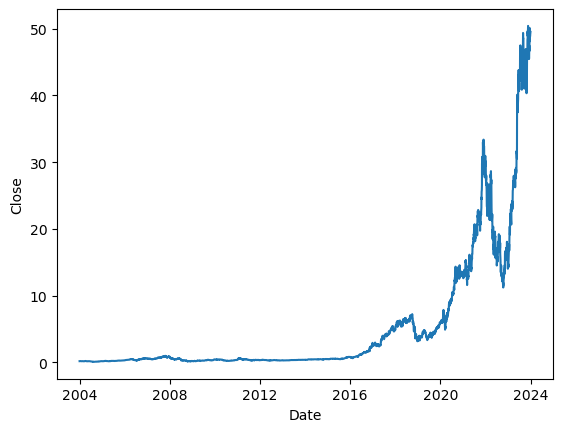

In [ ]:
# 그래프 모양 확인하기
sns.lineplot(df, x="Date", y="Close")

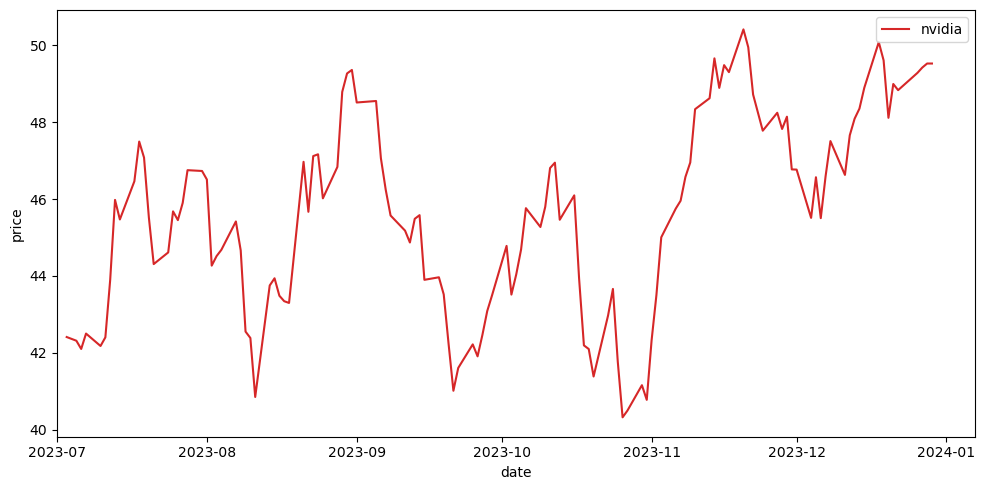

In [ ]:
# 확대해서 주기 확인하기
fig, ax = plt.subplots()
plt.plot('Date', 'Close', data=df[df.Date.dt.date >= datetime.date(2023, 7, 1)], label='nvidia', color='C3')
plt.xlim(datetime.date(2023, 7, 1),)
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()

- 주기가 약 40일마다 보이는거같고, 장이 열리는날로 환산하면 약 35가 주기로 보인다

In [ ]:
# 가법(덧셈)으로 계절성 확인하기
result = seasonal_decompose(df.Close, model='additive', period=35, two_sided=False)

/var/folders/kv/f0jcgy717lg4g1n2st55z70h0000gn/T/ipykernel_73804/1394325990.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  axs[1].hlines(result.trend.tail(1), df.Date.min(),df.Date.max(), label=f'{int(result.trend.tail(1))}', linestyles='--', colors='C1')


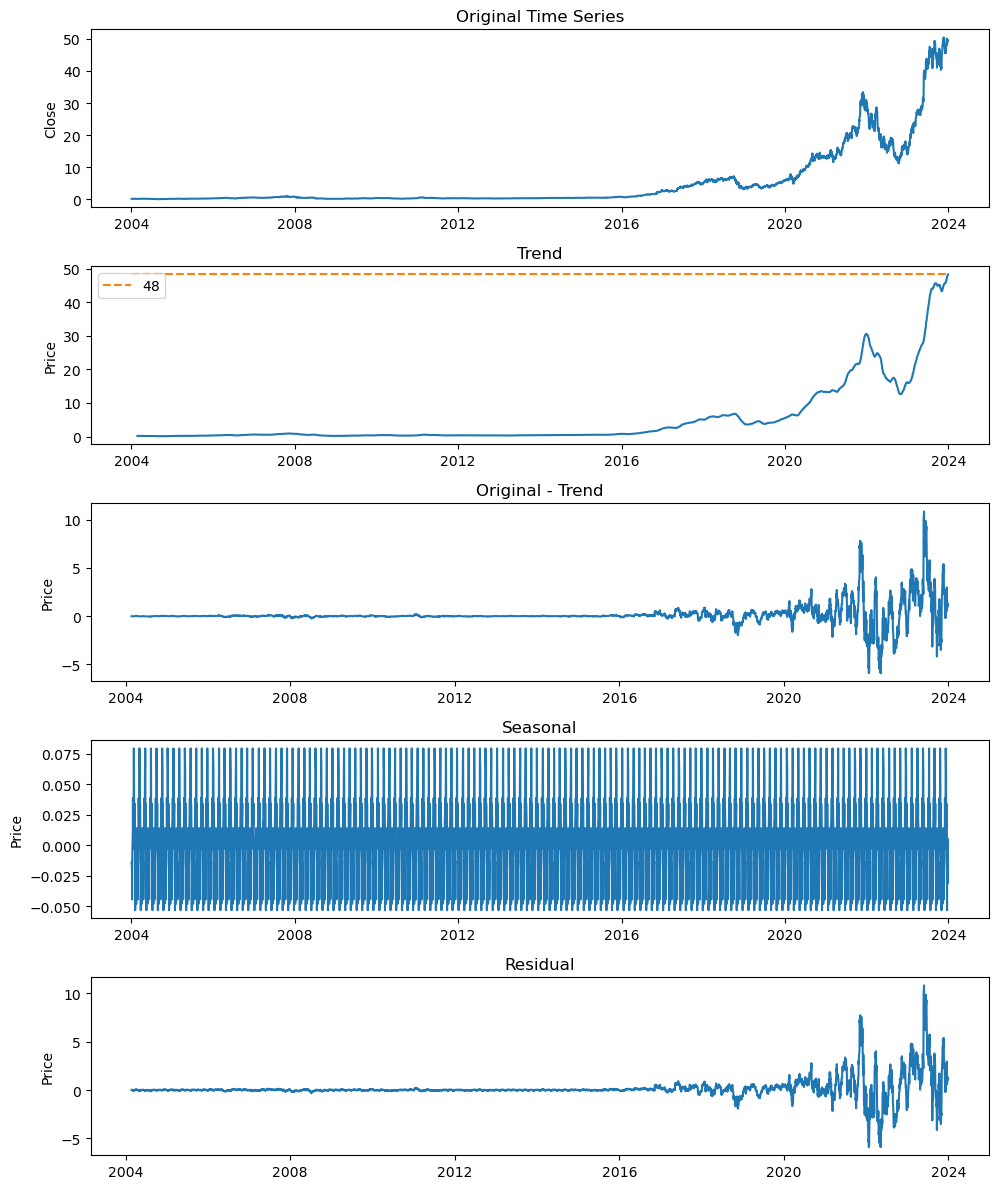

In [ ]:
# 시게열 데이터 분해 결과 그리기
## 시계열 데이터 분해 결과 그리기
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

# 원본 시계열 데이터
axs[0].plot('Date','Close', data=df)
axs[0].set_title('Original Time Series')
axs[0].set_ylabel('Close')

# 추세
axs[1].plot(df.Date, result.trend)
axs[1].hlines(result.trend.tail(1), df.Date.min(),df.Date.max(), label=f'{int(result.trend.tail(1))}', linestyles='--', colors='C1')
axs[1].legend()
axs[1].set_title('Trend')
axs[1].set_ylabel('Price')

# 원본-추세
axs[2].plot(df.Date, df.Close-result.trend)
axs[2].set_title('Original - Trend')
axs[2].set_ylabel('Price')

# 계절성
axs[3].plot(df.Date, result.seasonal)
axs[3].set_title('Seasonal')
axs[3].set_ylabel('Price')

# 잔차(노이즈)
axs[4].plot(df.Date, result.resid)
axs[4].set_title('Residual')
axs[4].set_ylabel('Price')

plt.tight_layout()
plt.show()

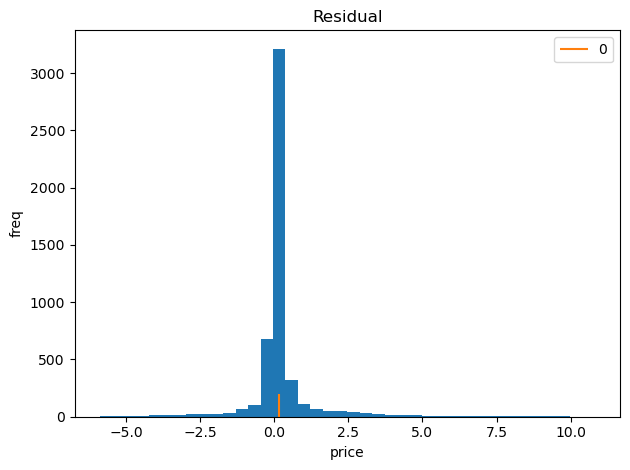

In [ ]:
# Residual 분포 분석하기
plt.hist(result.resid, bins=40)
plt.vlines(result.resid.mean(), 0, 200, colors='C1', label=f'{int(result.resid.mean())}')
plt.title('Residual')
plt.xlabel('price')
plt.ylabel('freq')
plt.legend()
plt.tight_layout()
plt.show()

- 2017년 이후로 급격히 주가가 변동되기 시작했다.
- 잔차의 분포도는 정규분포를 따르지 않는다.
- 그러니 2017이후로 짤라서 다시한번 분석하자.
- 또 급격하게 변화하는 부분이 있으니까 가법이아닌 승법(곱셈) 으로 계절성 확인 필요하다.

In [37]:
df_cut = df[df.Date.dt.date >= datetime.date(2017,1,1)].reset_index(drop=True)
result_cut = seasonal_decompose(df_cut.Close, model='multiplicative', period=35, two_sided=False)
df_cut

,Date,Open,High,Low,Close,Volume
0,2017-01-03,2.610000,2.659250,2.484500,2.550250,1501996000
1,2017-01-04,2.585000,2.637500,2.538250,2.609750,1199220000
2,2017-01-05,2.613250,2.645500,2.526250,2.543500,984296000
3,2017-01-06,2.571250,2.606250,2.530000,2.577500,822856000
4,2017-01-09,2.587500,2.700000,2.587500,2.682000,916248000
...,...,...,...,...,...,...
1755,2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000
1756,2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000
1757,2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000
1758,2023-12-28,49.643002,49.883999,49.411999,49.521999,246587000


/var/folders/kv/f0jcgy717lg4g1n2st55z70h0000gn/T/ipykernel_73804/2118213272.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  axs[1].hlines(result_cut.trend.tail(1), df_cut.Date.min(),df_cut.Date.max(), label=f'{int(result_cut.trend.tail(1))}', linestyles='--', colors='C1')


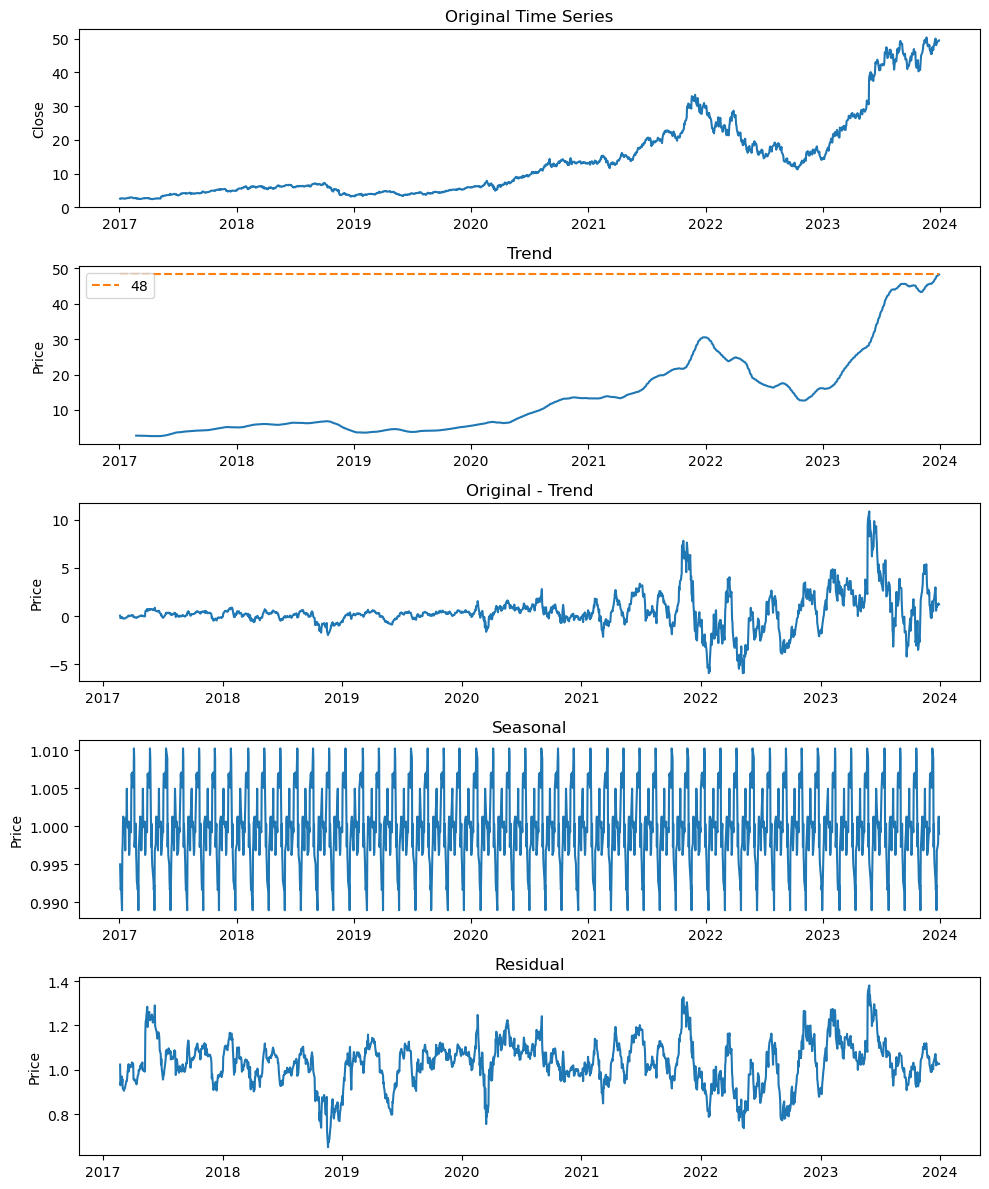

In [ ]:
# 시계열 데이터 분해 결과 그리기
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

# 원본 시계열 데이터
axs[0].plot('Date','Close', data=df_cut)
axs[0].set_title('Original Time Series')
axs[0].set_ylabel('Close')

# 추세
axs[1].plot(df_cut.Date, result_cut.trend)
axs[1].hlines(result_cut.trend.tail(1), df_cut.Date.min(),df_cut.Date.max(), label=f'{int(result_cut.trend.tail(1))}', linestyles='--', colors='C1')
axs[1].legend()
axs[1].set_title('Trend')
axs[1].set_ylabel('Price')

# 원본-추세
axs[2].plot(df_cut.Date, df_cut.Close-result_cut.trend)
axs[2].set_title('Original - Trend')
axs[2].set_ylabel('Price')

# 계절성
axs[3].plot(df_cut.Date, result_cut.seasonal)
axs[3].set_title('Seasonal')
axs[3].set_ylabel('Price')

# 잔차(노이즈)
axs[4].plot(df_cut.Date, result_cut.resid)
axs[4].set_title('Residual')
axs[4].set_ylabel('Price')

plt.tight_layout()
plt.show()

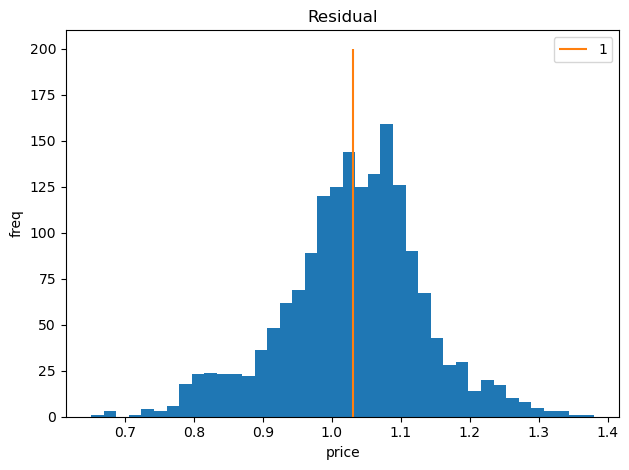

In [ ]:
# Residual 분포 분석하기
plt.hist(result_cut.resid, bins=40)
plt.vlines(result_cut.resid.mean(), 0, 200, colors='C1', label=f'{int(result_cut.resid.mean())}')
plt.title('Residual')
plt.xlabel('price')
plt.ylabel('freq')
plt.legend()
plt.tight_layout()
plt.show()


- 이상적인 잔차 분포가 나오고 적절한 주기 설정이었다고 볼 수 있다. (한달반, 장 열린거 기준 35일)
- 2017 이후로 한달 반정도의 일정한 주기(계절성)을 띈다고 볼 수 있겠다.
- 그러나 주가 추세와 계절성이 완전 일치하지는 않으며, 상황에따라 변수가 많다는 것을 의미한다. (외부요인)

# 2. 모델 성능 및 개선 비교
### 여러가지 모델을 적용하고 얼마나 예측이 잘 되는지 확인해본다.

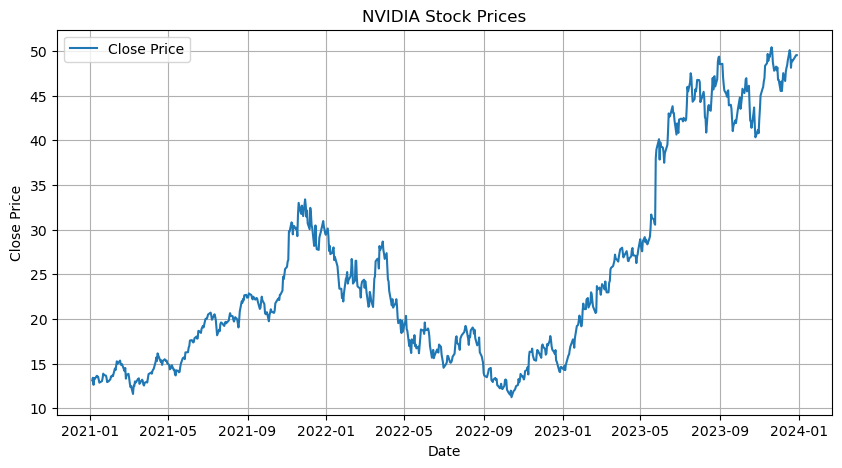

In [ ]:
# 모든 모델에 대해서 같은 기간을 예측하기 위해서 데이터를 나눈다.
# 마지막 두달을 예측 하는걸로 해보자.
df = pd.read_csv("nvidia_stock_prices.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']].dropna()

# 코로나 기간 제외하기 (예: 2020-03-01 ~ 2020-12-31)
df = df.loc[((df.index < '2020-03-01') | (df.index > '2020-12-31')) & (df.index>'2021-01-01')]

# 데이터 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price')
plt.title('NVIDIA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


## 2-1 ARIMA모델

In [ ]:
# 정상성 확인 및 차분하기
## ADF Test for Stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Data is non-stationary. Differencing required.")
    df['Close_diff'] = df['Close'].diff().dropna()
else:
    print("Data is stationary.")



ADF Statistic: -0.06900464489227597
p-value: 0.9524396083234313
Data is non-stationary. Differencing required.


In [106]:
# 최적 arima parameter 찾기
auto_model = auto_arima(df['Close'].dropna(), seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1841.279, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1838.981, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1840.954, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1840.953, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1839.600, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1842.832, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.656 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  753
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -917.490
Date:                Wed, 20 Nov 2024   AIC                           1838.981
Time:                        15:24:44   BIC                           1848.226
Sample:                             0   HQIC                          1842.543
          

In [ ]:
# ARIMA 모델 학습하기
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

model = ARIMA(train, order=auto_model.order)
arima_model = model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  602
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -634.613
Date:                Wed, 20 Nov 2024   AIC                           1271.225
Time:                        15:24:47   BIC                           1275.624
Sample:                             0   HQIC                          1272.937
                                - 602                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4838      0.020     24.095      0.000       0.444       0.523
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                96.37
Prob(Q):                              0.69   Pr

/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# 6. 예측하기
forecast = arima_model.forecast(steps=len(test))
forecast_index = test.index

# 7. 평가하기기
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.2f}")


RMSE: 14.54


/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


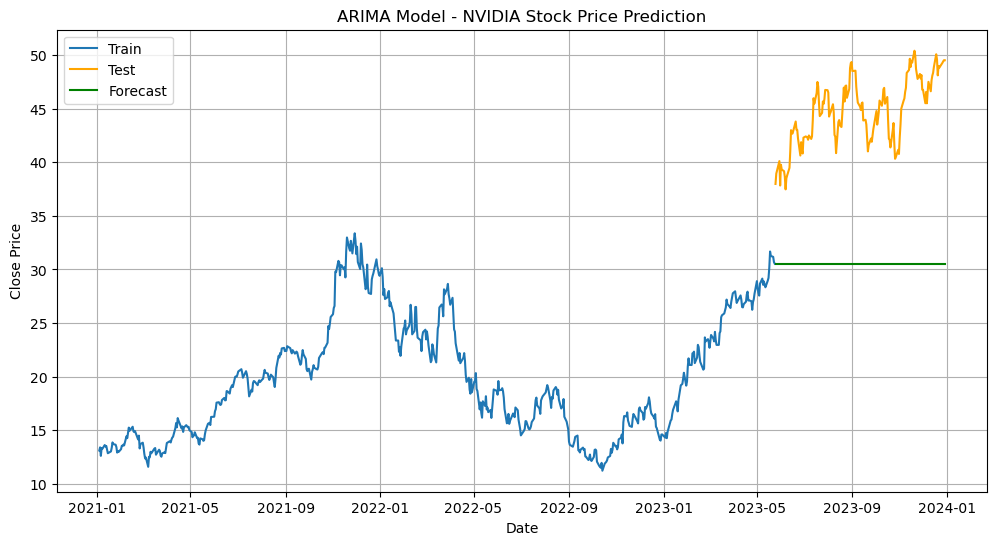

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.title('ARIMA Model - NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [143]:
tmp = get_score(np.array(test), np.array(forecast))
df_score = pd.DataFrame([['arima',tmp[0],tmp[1],tmp[2],tmp[3],tmp[4]]], columns=['Label','MSE','MAE','RMSE','MAPE','MSPE'])
df_score

,Label,MSE,MAE,RMSE,MAPE,MSPE
0,arima,211.310726,14.206066,14.536531,31.417098,461.191268


In [142]:
np.array(test)

array([37.97999954, 38.94599915, 40.11100006, 37.83399963, 39.77000046,
       39.32699966, 39.17100143, 38.65399933, 37.47499847, 38.50999832,
       38.77000046, 39.48199844, 41.02199936, 42.99700165, 42.65299988,
       42.69200134, 43.80799866, 43.04499817, 43.02500153, 42.20899963,
       40.63199997, 41.87599945, 41.11700058, 40.8219986 , 42.30199814,
       42.4129982 , 42.31700134, 42.10300064, 42.50299835, 42.18000031,
       42.40499878, 43.90200043, 45.97700119, 45.46900177, 46.46099854,
       47.49399948, 47.07699966, 45.52000046, 44.30899811, 44.61199951,
       45.67900085, 45.45199966, 45.90000153, 46.75      , 46.72900009,
       46.50699997, 44.26900101, 44.51499939, 44.68000031, 45.41699982,
       44.66400146, 42.55400085, 42.38800049, 40.85499954, 43.75299835,
       43.93999863, 43.48600006, 43.34400177, 43.29899979, 46.96699905,
       45.66799927, 47.11600113, 47.1629982 , 46.01800156, 46.83499908,
       48.7840004 , 49.26399994, 49.35499954, 48.50899887, 48.54

- ARIMA 모델로는 계속해서 데이터를 바꿔도 차분 0인 이전 데이터의 평균치를 예측하는 것이 가장 좋은 성능으로 나타났다.
- Nvidia 주가 데이터의 주가가 정말 시간에 따른 변화량이 랜덤하다는 것을 의미한다.
- 다른 모델로 예측이 필요할 거 같다.  (1번 분석에서 사용한 주기를 활용하면 좋을 것 같음)

## 2-2 LSTM
- 1번 분석에서 찾은 주기성을 활용하여 window size를 설정한 LSTM모델을 돌려보자
- 'Close'를 예측하되 나머지 feature들도 모두 활용하여 성능을 높여야 한다.

In [102]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv("nvidia_stock_prices.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

features = df[['Open', 'High', 'Low', 'Volume', 'Close']]
target = df['Close']

# 데이터 정규화하기 (MinMax Scaler)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

window_size = 30  # 60일간의 데이터로 그 다음 날 예측하기
Xy = utils.create_sequences(scaled_features, window_size)  # Close가 target이므로 index 3
X = Xy[:,:,:]
y = Xy[:,:,4]

# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# 모델 생성하기
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# 모델 컴파일하기
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 모델 학습하기
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# 전체 예측 및 결과 확인하기
predicted = model.predict(X)


Epoch 1/10


/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-20 15:32:20.715547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.3408e-04 - val_loss: 0.0045
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.1515e-06 - val_loss: 0.0081
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.9997e-06 - val_loss: 0.0082
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0130e-05 - val_loss: 0.0108
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.9234e-06 - val_loss: 0.0127
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.1954e-06 - val_loss: 0.0149
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.7495e-06 - val_loss: 0.0193
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.6566e-06 - val_loss: 0.0189
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.3353e-06 - val_loss: 0.0191
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.8723e-06 - val_loss: 0.0224
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [125]:
# %%
predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predicted.shape[0], 4)), predicted), axis=1)
)[:, 4]
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y.shape[0], 4)), y[:,-1].reshape(-1,1)), axis=1)
)[:, 4]


In [126]:
df_rst = pd.DataFrame({
    # 'date' : df['Date'][window_size:],
    'date' : df.index[window_size:],
    'pred_prices' : predicted_prices,
    'real_prices' : actual_prices
})

In [ ]:


tmp = get_score(df_rst['real_prices'][split:], df_rst['pred_prices'][split:])
tmp = get_score(df_rst['real_prices'][split:], df_rst['pred_prices'][split:])
df_score = pd.DataFrame([['lstm',tmp[0],tmp[1],tmp[2],tmp[3],tmp[4]]], columns=['Label','MSE','MAE','RMSE','MAPE','MSPE'])
df_score

,Label,MSE,MAE,RMSE,MAPE,MSPE
0,lstm,66.75674,5.307295,8.17048,19.04849,172.536712


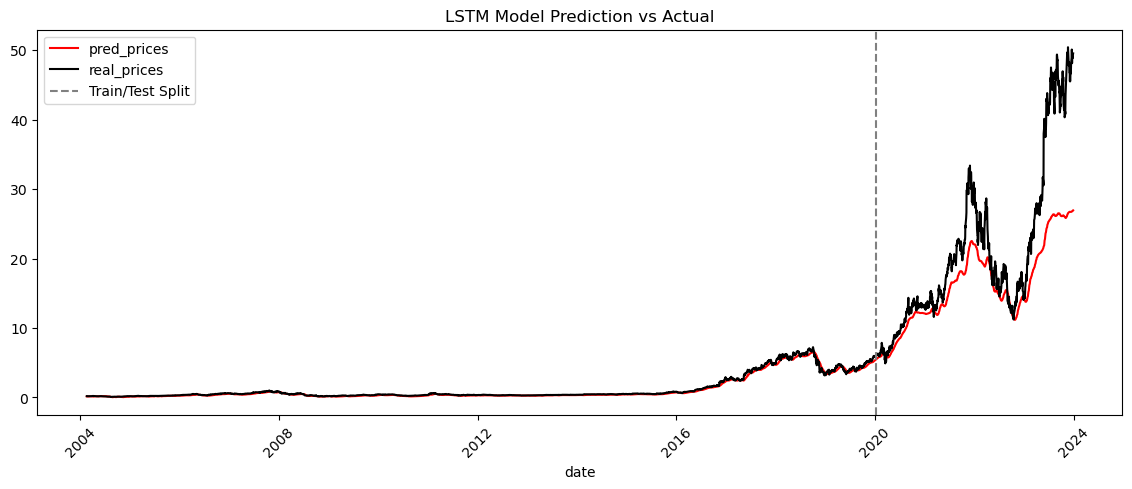

In [ ]:
def draw_timeseries_graph(df, x, ys, test_size=0.2, colors=None, title = None, ytitle = None) : 
    if colors == None : colors = [None for i in range(len(ys))]

    plt.figure(figsize=(14,5))
    for i in range(len(ys)) :
        sns.lineplot(df, x=x, y=ys[i], color=colors[i], label=ys[i])

    plt.axvline(x=df[x][int(df.shape[0]*(1-test_size))], color='grey', linestyle='--', label='Train/Test Split')

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ytitle)
    plt.legend()
    plt.xticks(rotation=45)  # x축 레이블 회전하기
    plt.show()

draw_timeseries_graph(df_rst, 'date', ['pred_prices','real_prices'], 0.2, ['red','black'], "LSTM Model Prediction vs Actual")

In [ ]:
# 기존 30보다 변동성에 더 예민하게하려면 window_size를 더 줄이는게 좋을것같다
df = pd.read_csv("nvidia_stock_prices.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

features = df[['Open', 'High', 'Low', 'Volume', 'Close']]
target = df['Close']

# 데이터 정규화하기(MinMax Scaler)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

window_size = 20  # 20일간의 데이터를 사용하여 다음 날 예측하기
Xy = utils.create_sequences(scaled_features, window_size)  # Close가 target이므로 index 3
X = Xy[:,:,:]
y = Xy[:,:,4]

# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 모델 생성하기
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# 모델 컴파일하기
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 모델 학습하기
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# 전체 예측 및 결과 확인하기
predicted = model.predict(X)

predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predicted.shape[0], 4)), predicted), axis=1)
)[:, 4]
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y.shape[0], 4)), y[:,-1].reshape(-1,1)), axis=1)
)[:, 4]

df_rst = pd.DataFrame({
    # 'date' : df['Date'][window_size:],
    'date' : df.index[window_size:],
    'pred_prices' : predicted_prices,
    'real_prices' : actual_prices
})

df_rst


Epoch 1/10


/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-20 15:34:05.349744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 2.9818e-04 - val_loss: 0.0096
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.3561e-06 - val_loss: 0.0129
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.2260e-06 - val_loss: 0.0174
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.6253e-06 - val_loss: 0.0202
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.4188e-06 - val_loss: 0.0199
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.5341e-06 - val_loss: 0.0216
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.4138e-06 - val_loss: 0.0210
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3967e-06 - val_loss: 0.0233
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.6808e-06 - val_loss: 0.0248
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.7708e-06 - val_loss: 0.0233
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,date,pred_prices,real_prices
0,2004-02-02,0.205429,0.185417
1,2004-02-03,0.204319,0.188417
2,2004-02-04,0.203165,0.187750
3,2004-02-05,0.202306,0.182667
4,2004-02-06,0.200700,0.185417
...,...,...,...
5008,2023-12-22,26.538170,48.990002
5009,2023-12-26,26.555102,48.830002
5010,2023-12-27,26.573359,49.278999
5011,2023-12-28,26.591023,49.417000


In [ ]:
tmp = get_score(df_rst['real_prices'][split:], df_rst['pred_prices'][split:])
df_score = pd.DataFrame([['lstm',tmp[0],tmp[1],tmp[2],tmp[3],tmp[4]]], columns=['Label','MSE','MAE','RMSE','MAPE','MSPE'])
df_score

,Label,MSE,MAE,RMSE,MAPE,MSPE
0,lstm,66.140679,5.083782,8.132692,17.345404,167.158377


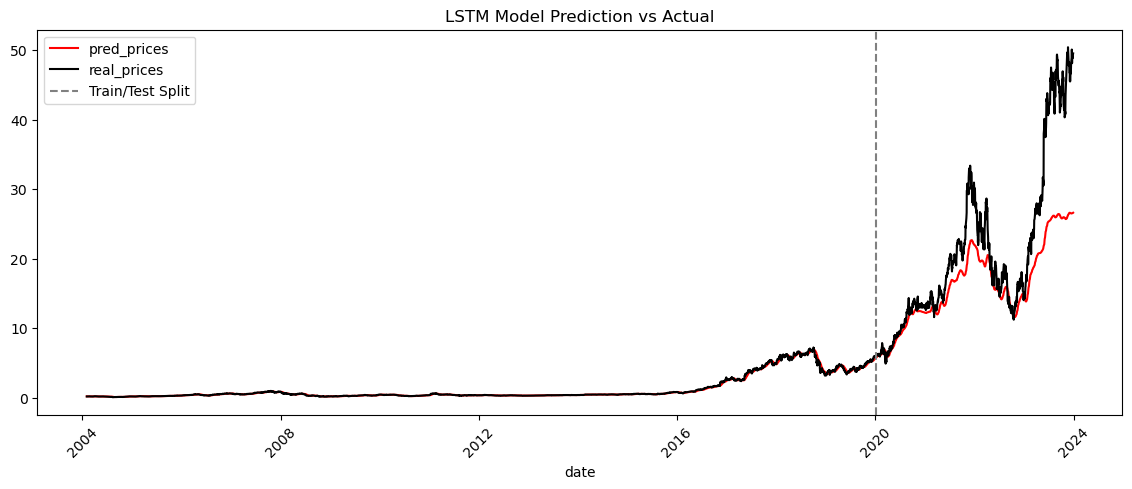

In [132]:
draw_timeseries_graph(df_rst, 'date', ['pred_prices','real_prices'], 0.2, ['red','black'], "LSTM Model Prediction vs Actual")

- window_size를 감소시켰더니, 변화에 더 민감하게 반응. 약간이나마 TREND를 windowsize 45에비해 더 잘 쫓아감

In [ ]:
# 이번엔 모델을 좀더 복잡하게 사용하보자
from keras.layers import LSTM, Dense, Dropout, Bidirectional

model2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 모델 학습하기
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# 전체 예측 및 결과 확인하기
predicted = model2.predict(X)

predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predicted.shape[0], 4)), predicted), axis=1)
)[:, 4]
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y.shape[0], 4)), y[:,-1].reshape(-1,1)), axis=1)
)[:, 4]

df_rst = pd.DataFrame({
    # 'date' : df['Date'][window_size:],
    'date' : df.index[window_size:],
    'pred_prices' : predicted_prices,
    'real_prices' : actual_prices
})

tmp = get_score(df_rst['real_prices'][split:], df_rst['pred_prices'][split:])
df_score = pd.DataFrame([['lstm',tmp[0],tmp[1],tmp[2],tmp[3],tmp[4]]], columns=['Label','MSE','MAE','RMSE','MAPE','MSPE'])
df_score

Epoch 1/10


/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-20 15:42:38.195589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 1.7517e-04 - val_loss: 0.0201
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 8.7006e-06 - val_loss: 0.0242
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 1.2061e-05 - val_loss: 0.0193
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 9.0963e-06 - val_loss: 0.0210
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 9.1233e-06 - val_loss: 0.0241
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 7.5563e-06 - val_loss: 0.0244
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 6.1592e-06 - val_loss: 0.0292
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 6.3183e-06 - val_loss: 0.0301
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 7.1629e-06 - val_loss: 0.0333
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 5.8994e-06 - val_loss: 0.0319


2024-11-20 15:45:05.031710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


,Label,MSE,MAE,RMSE,MAPE,MSPE
0,lstm,89.19054,6.116656,9.444074,21.521793,229.215863


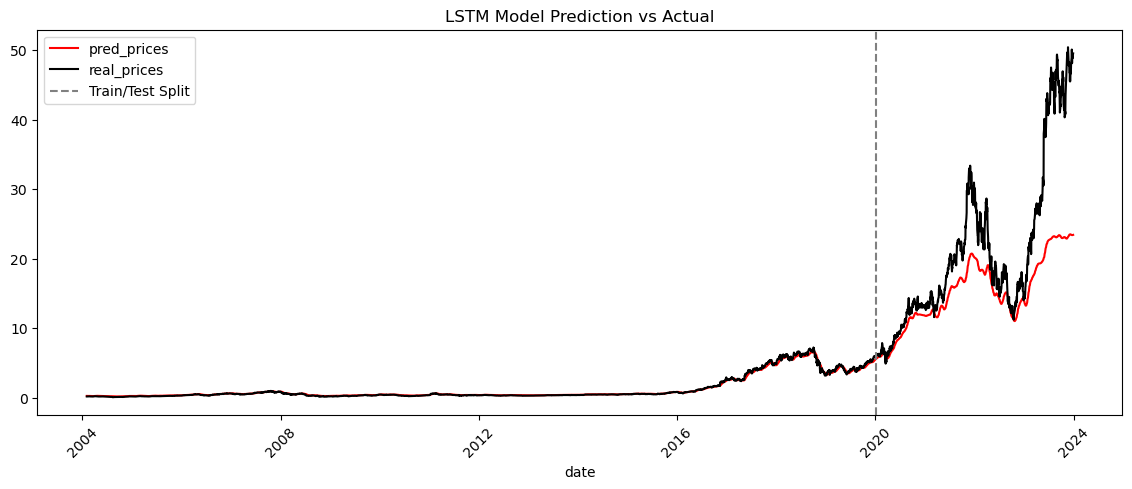

In [145]:
draw_timeseries_graph(df_rst, 'date', ['pred_prices','real_prices'], 0.2, ['red','black'], "LSTM Model Prediction vs Actual")

- 과적합 방지로 넣은 Dropout이 민감하게 변하는 CLose값을 따라가지 못하는 것으로 보인다.
- 일반적으로는 과적합되면 모델의 성능이 떨어지지만, nvidia 주가의경우 갑자기 급상승한 특이 case기 때문에,
오히려 이런  부분이 잘 적용되도록 간단하고 과적합되는 모델을 사용하는것이 실제 예측에는 더 도움이 된 것으로 보인다.



## 3. 모델 비교 및 최종 모델 선정하기
- Train, Test 데이터 동일시 하여, 최종 성능 지표 비교 및 모델 선정하기

In [ ]:
df = pd.read_csv("nvidia_stock_prices.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

features = df[['Open', 'High', 'Low', 'Volume', 'Close']]
target = df['Close']

# 데이터 정규화하기 (MinMax Scaler)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)


In [149]:
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Data is non-stationary. Differencing required.")
    df['Close_diff'] = df['Close'].diff().dropna()
else:
    print("Data is stationary.")

ADF Statistic: 2.0913618670484806
p-value: 0.9987805185477441
Data is non-stationary. Differencing required.


In [150]:
# 최적 arima parameter 찾기
auto_model = auto_arima(df['Close'].dropna(), seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6642.337, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5191.815, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6640.337, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4632.648, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4288.747, Time=0.33 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3920.742, Time=0.37 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3753.381, Time=0.48 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=3099.808, Time=2.71 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.91 sec

Best model:  ARIMA(5,2,1)(0,0,0)[0] intercept
Total fit time: 

In [151]:
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

model = ARIMA(train, order=auto_model.order)
arima_model = model.fit()
print(arima_model.summary())

/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4026
Model:                 ARIMA(5, 2, 1)   Log Likelihood                5865.293
Date:                Wed, 20 Nov 2024   AIC                         -11716.587
Time:                        15:52:48   BIC                         -11672.487
Sample:                             0   HQIC                        -11700.959
                               - 4026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0392      0.005     -8.401      0.000      -0.048      -0.030
ar.L2          0.0177      0.006      2.833      0.005       0.005       0.030
ar.L3          0.0530      0.006      9.364      0.0

/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# 6. 예측하기기
forecast = arima_model.forecast(steps=len(test))
forecast_index = test.index

tmp = get_score(np.array(test), np.array(forecast))
df_score = pd.DataFrame([['arima',tmp[0],tmp[1],tmp[2],tmp[3],tmp[4]]], columns=['Label','MSE','MAE','RMSE','MAPE','MSPE'])
df_score

/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chemseok/miniforge3/envs/standard/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Label,MSE,MAE,RMSE,MAPE,MSPE
0,arima,246.041313,11.891988,15.685704,47.149241,732.314811


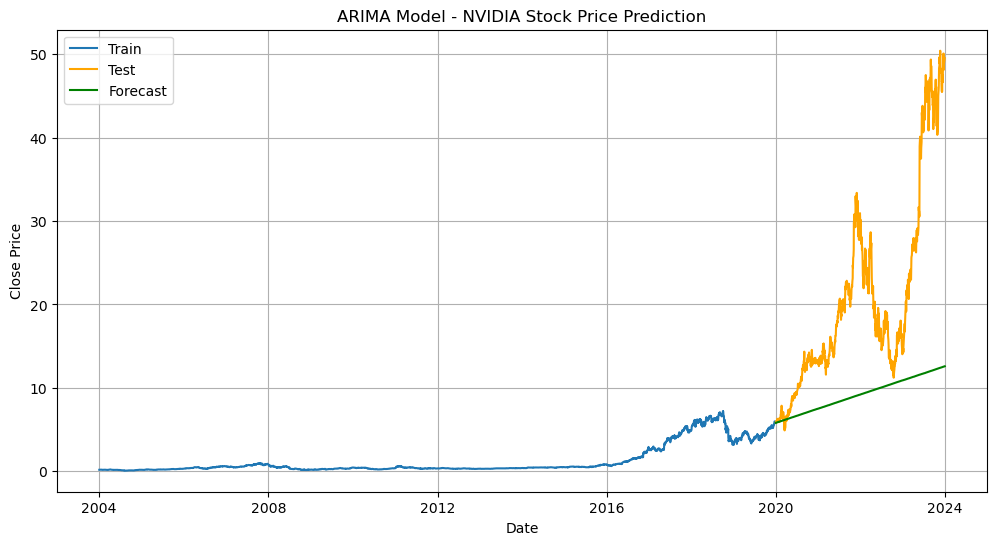

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.title('ARIMA Model - NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

- 되려 전처리로 데이터를 지운것이 arima 모델에 악영향을 끼쳤다.
- 그렇지만 여전히 차분이 매우 낮고 0은아니지만 직선으로 값을 예측하는게 한계였다.

In [163]:
new_score = pd.DataFrame([['lstm1',89.19054,6.116656,9.444074,21.521793,229.215863],
                          ['lstm2', 66.140679, 5.083782, 8.132692, 17.345404, 167.158377],
                          ['lstm3', 89.19054,6.116656,9.444074,21.521793,229.215863]
                          ], columns=['Label','MSE','MAE','RMSE','MAPE','MSPE'])
df_score = pd.concat([df_score, new_score], axis=0)
df_score

,Label,MSE,MAE,RMSE,MAPE,MSPE
0,arima,246.041313,11.891988,15.685704,47.149241,732.314811
0,lstm1,89.190540,6.116656,9.444074,21.521793,229.215863
1,lstm2,66.140679,5.083782,8.132692,17.345404,167.158377
2,lstm3,89.190540,6.116656,9.444074,21.521793,229.215863


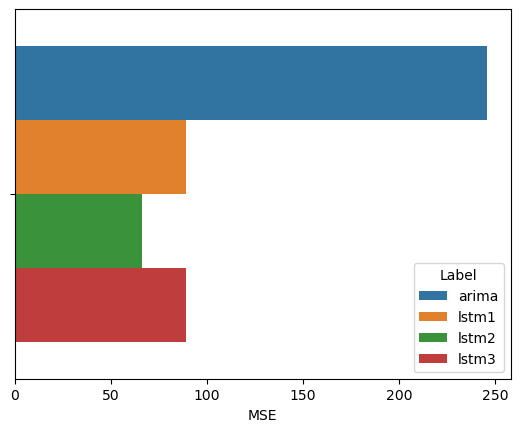

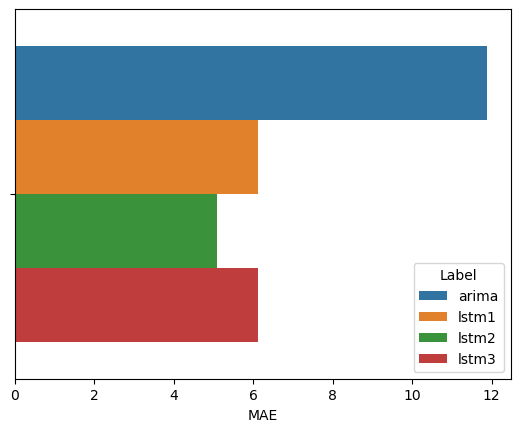

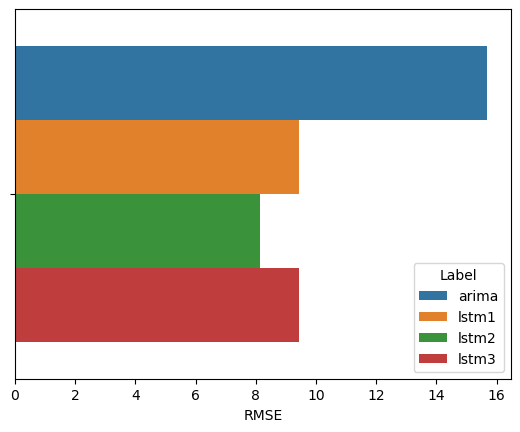

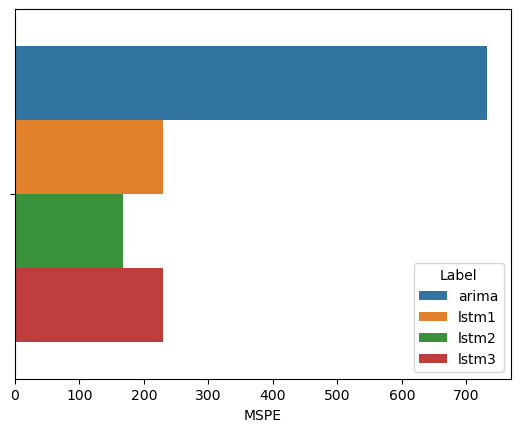

In [ ]:
# 성능 시각화하기
sns.barplot(df_score,x='MSE',hue='Label')
plt.show()
sns.barplot(df_score,x='MAE',hue='Label')
plt.show()
sns.barplot(df_score,x='RMSE',hue='Label')
plt.show()
sns.barplot(df_score,x='MSPE',hue='Label')
plt.show()


### 결론
- 계절성을 확인하고자 주가를 시각화하고, 최근 데이터 기준으로 한달반정도의 주기를 가지는 것을 확인했고, 해당 기간으로 계절성을 확인해본 결과 잔차가 정규분포를 따름을 확인하였다.
- ARIMA 모델의 경우 시간의 종속성을 가지게 되는데, 시간에 따른 변화량에 일정한 패턴이 없기 때문에 제대로 예측하지 못하였다.
- 그래프 시각화 확인 및 외부요인에 대한 인자를 활용하여 코로나 시기와 급격하게 변화하기 전 데이터를 없애보았지만, 오히려 성능이 하락하는 것을 확인할 수 있었다.
- LSTM 딥러닝 모델을 활용하여 다른 특징들도 중요 인자로 놓고 training 한 결과 주가의 변동성을 매우 잘 따라 가는 것을 확인하였다. (lstm1)
- 좀더 민감하게 주가변동을 예측해야겠다고 생각해서 window_size를 더 줄여봤고 더 높은 점수를 획득할 수 있었다.(lstm2)
- 복잡하고 과접합을 방지한 모델에서 더 높은 성능을 기대했으나, 오히려 변동성이 줄게 되어 최근 확 뛰는 주가를 예측하기 어려웠다. (lstm3)

### 따라서 간단하지만 다른 인자들을 고려해서 예측할 수 있는 LSTM2 모델이 가장 성능이 좋았으며, 일반적으로는 과적합을 방지하기 위해 넣는 장치인 window_size 길게하거나, Dropout을 넣거나, 앞뒤로 다 예측하게하거나 하는 방법을 넣으면 오히려 최근 주가에대한 예측률을 떨어짐을 확인할 수 있었고, 따라서 최종적으로 선택한 모델은 LSTM2가 되겠다.